In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
directory = '/content/drive/My Drive/Kaggle/app review'

###Imports

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import stop_words
from wordcloud import WordCloud
from operator import itemgetter

In [0]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


###Leitura dos dados

In [0]:
data_google_store = pd.read_csv(f'{directory}/googleplaystore.csv')
data_google_review = pd.read_csv(f'{directory}/googleplaystore_user_reviews.csv')

###Exploração


In [58]:
data_google_store.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [8]:
data_google_review.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


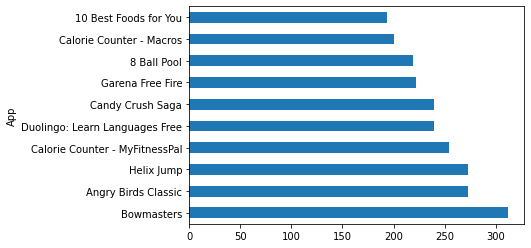

In [57]:
data_google_review.groupby(['App'])['Translated_Review'].count().sort_values(ascending=False).head(10).plot.barh()

In [37]:
data_google_review[data_google_review['App']=='Angry Birds Classic'].head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
7352,Angry Birds Classic,Way many ads. I remember Angry Birds first cam...,Negative,-0.125000,0.483333
7353,Angry Birds Classic,Angry Birds used game could tap play heart's c...,Negative,-0.065909,0.588636
7354,Angry Birds Classic,NaN,NaN,NaN,NaN
7355,Angry Birds Classic,"Good job Rovio, good job joining pay play band...",Positive,0.266667,0.583333
7356,Angry Birds Classic,"The ""Mighty League"" part unplayable. It consta...",Negative,-0.073333,0.400000


###Definindo dado de trabalho


In [0]:
data = data_google_review[data_google_review['App']=='Angry Birds Classic']

###Limpando dado


In [0]:
def clean_function (df,columns):
  for column in columns:
    df[column] = df[column].str.lower()
  
  df.columns = map(str.lower, df.columns)
  df = df.dropna()
  
  return df

In [180]:
columns = data[['App', 'Translated_Review', 'Sentiment']].columns.values
data = clean_function(data, columns)
data = data.replace(regex=r'[/,.?-]',value='')
data['category'] = 'Outro'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Função de agrupamento

In [0]:
def pooler(documents, iters, min_df=5, max_df=0.7, ngram=(1, 3), max_features=1000):
    # documents vectorizer
    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        ngram_range=ngram,
        max_features=max_features
    ).fit(documents)
    vectorized = vectorizer.transform(documents)
    
    # pooler model
    sse = []
    models = []
    for k in iters:
        model = MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=42).fit(vectorized)
        models.append(model)
        sse.append(model.inertia_)
        model.predict(vectorized)
        
    return models, sse, vectorized, vectorizer.get_feature_names()

def get_model(models, k):
    c = ((k - 2) // 2)
    return models[c]

###Removendo stopwords

In [0]:
def remover_stop_word(df, column):
  stop_words_list = list(stop_words.ENGLISH_STOP_WORDS)
  regex = r'\b(?:{})\b'.format('|'.join(stop_words_list))
  new_column = f'{column}_cleaned'
  df[new_column] = df[column].str.replace(regex, '')
  return df
data = remover_stop_word(data, 'translated_review')

###Avaliando agrupamento

In [0]:
data = data.replace(regex=r'[/,.?-]',value='')


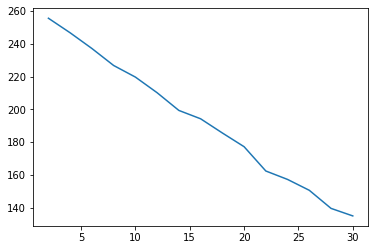

In [188]:
iters = range(2, 30 + 1, 2)
models, sse, vectorized, vocabulary = pooler(data.translated_review_cleaned.values, iters, min_df=5, max_df=0.6, max_features=1500)

plt.plot(iters, sse)
plt.show()

## Agrupando comentários

In [191]:
k = 15
model = get_model(models, k)
model.predict(vectorized)

data['cluster'] = model.predict(vectorized)
data.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,translated_review_cleaned,category,cluster
7352,angry birds classic,way many ads i remember angry birds first came fun now nothing constant ads forced videos timers proceed makes game virtually unplayable i've uninstalled it a shame too but i'm going held hostage ads videos bad enough youtube it and rovio youtube,negative,-0.125000,0.483333,way ads remember angry birds came fun constant ads forced videos timers proceed makes game virtually unplayable 've uninstalled shame 'm going held hostage ads videos bad youtube rovio youtube,Outro,5
7353,angry birds classic,angry birds used game could tap play heart's content now gone feetopay (sic) read reviews see well received not well understatement i'd say more gain 50 stars read new paragraph meanwhile watch unskippable halfminutelong ads,negative,-0.065909,0.588636,angry birds used game tap play heart's content gone feepay (sic) read reviews received understatement 'd say gain 50 stars read new paragraph watch unskippable halfminutelong ads,Outro,5
7355,angry birds classic,good job rovio good job joining pay play band wagon i mind ads add cliche pay win features like coins gems why disappointing but i doubt company would ever change game well money pays bills righti doubt company guys even look feedback reviews otherwise would never strayed darkside free play,positive,0.266667,0.583333,good job rovio good job joining pay play band wagon mind ads add cliche pay win features like coins gems disappointing doubt company change game money pays bills right doubt company guys look feedback reviews strayed darkside free play,Outro,4
7356,angry birds classic,"the ""mighty league"" part unplayable it constantly freezes after close everything start freeze again rovio known years care less don't waste time",negative,-0.073333,0.400000,"""mighty league"" unplayable constantly freezes close start freeze rovio known years care don't waste time",Outro,13
7357,angry birds classic,the miller lite beer ads really need removed there kids play this no needs liquor adscommercials adults know what's choose that otherwise great game shut wifidata want ad free,positive,0.250000,0.537500,miller lite beer ads really need removed kids play needs liquor adscommercials adults know 's choose great game shut wifidata want ad free,Outro,9


## Nuvem de palavras

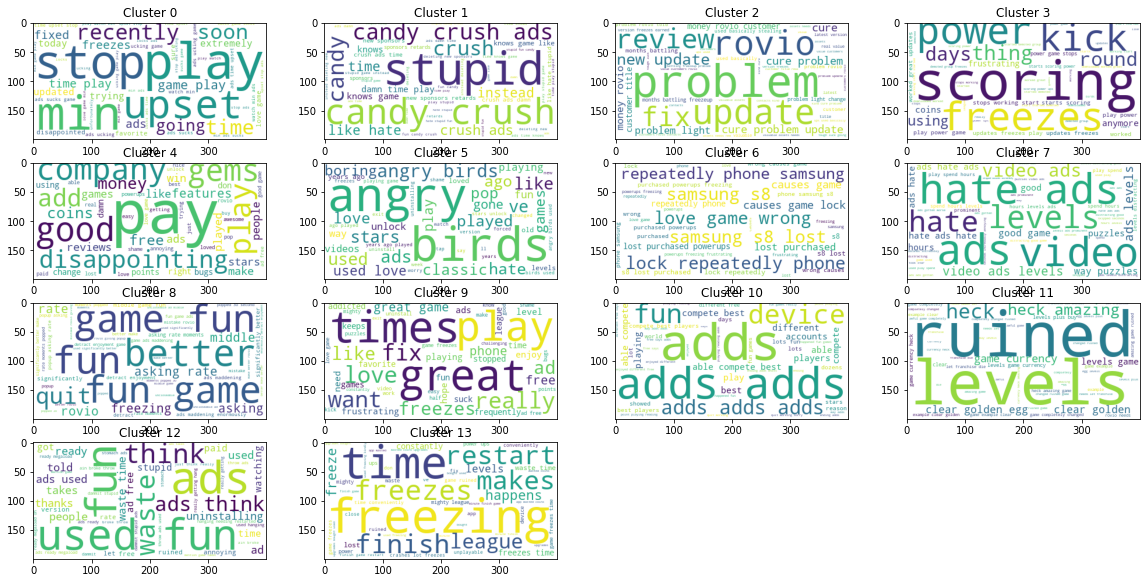

In [197]:
mw = 50

fig = plt.figure(figsize = (20, 15))
vocabulary.append('')

i = 0
for r in model.cluster_centers_:
    dictionary = { vocabulary[k]: r[k] for k in np.argsort(r)[::-1][:mw] }
    dictionary = {k: v for k, v in dictionary.items() if v > 0}

    wc = WordCloud(background_color='white', max_words=mw, relative_scaling=0.1, normalize_plurals=True)
    image = wc.generate_from_frequencies(dictionary)

    ax = fig.add_subplot(6, 4, (i + 1))
    plt.imshow(image)
    ax.set_title(f'Cluster {i}')
    i = i + 1

###Melhores exemplos

In [0]:
def sort_best_binds(key):
    # calculate similarities
    similarities = []
    centroid = model.cluster_centers_[key]
    for v in vectorized:
        similarities.append(cosine_similarity([centroid], v))

    # best binds
    indexes = np.array([s[0][0] for s in similarities])
    indexes = np.argsort(indexes)[::-1]
    
    return indexes

###Categorias

In [0]:
maps = {
    0: 'stop play',
    1: 'candy crush',
    2: 'problem fix',
    3: 'scoring freezes',
    4: 'good pay',
    5: 'angry birds',
    6: 'cellphone',
    7: 'ads',
    8: 'game fun',
    9: 'times play',
    10: 'ads',
    11: 'ruined levels',
    12: 'fun',
    13: 'time freezing'}

###Categorizar agrupamento

In [204]:
top_binds = 20

for key in maps:
    if maps[key]:
        
        # best binds
        indexes = sort_best_binds(key)

        # labeling records
        data['category'].iloc[indexes[:top_binds]] = maps[key]
        data.groupby(['category'])['translated_review_cleaned'].count()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_

In [206]:
data.groupby(['category'])['translated_review_cleaned'].count().sort_values(ascending=False)

category
Outro              61
ads                33
times play         20
time freezing      20
fun                20
problem fix        17
angry birds        17
stop play          15
good pay           15
cellphone          13
scoring freezes    12
ruined levels      12
game fun           9 
candy crush        9 
Name: translated_review_cleaned, dtype: int64

In [0]:
df = data[data['category'] != 'Outro']

## TF-IDF e CountVectorizer

In [210]:
documents = df.translated_review_cleaned.values

vectorizer = TfidfVectorizer(ngram_range=(1, 3),max_features=1500,min_df=5, max_df=0.8).fit(documents)
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=1500,
                min_df=5, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [215]:
X = vectorizer.transform(documents)
y = df.category.values
''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classifier = LogisticRegression(
    multi_class='ovr',
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
).fit(X_train, y_train)

classifier

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###Resultado do teste

In [218]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

            ads       0.80      1.00      0.89         8
    angry birds       0.50      1.00      0.67         6
    candy crush       1.00      1.00      1.00         2
      cellphone       1.00      0.67      0.80         3
            fun       1.00      0.45      0.62        11
       game fun       1.00      1.00      1.00         2
       good pay       0.83      0.83      0.83         6
    problem fix       1.00      1.00      1.00         5
  ruined levels       0.00      0.00      0.00         2
scoring freezes       1.00      1.00      1.00         4
      stop play       1.00      1.00      1.00         4
  time freezing       1.00      1.00      1.00         7
     times play       0.80      1.00      0.89         4

       accuracy                           0.84        64
      macro avg       0.84      0.84      0.82        64
   weighted avg       0.87      0.84      0.83        64



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Resultado com base real

In [0]:
real_data = data[~data['translated_review_cleaned'].isna()]
real_data['label'] = classifier.predict(vectorizer.transform(data.translated_review_cleaned.values))

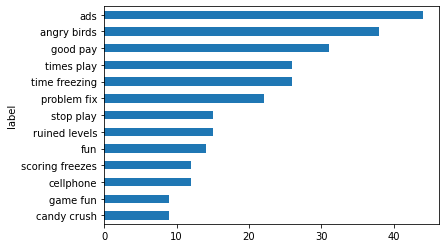

In [221]:
real_data.groupby(['label'])['translated_review_cleaned'].count().sort_values(ascending=True).plot.barh()

###Bigrama e Trigrama

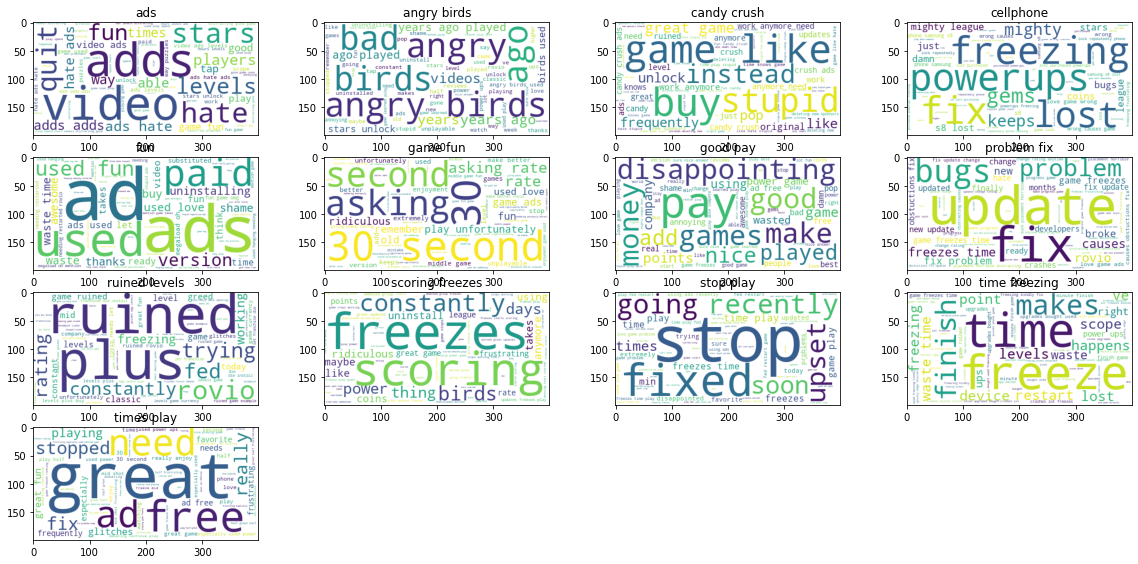

In [226]:
mw = 70
fig = plt.figure(figsize = (20, 12))

for i, v in enumerate(classifier.classes_):
    coefficients = classifier.coef_[i]
    keys = coefficients.argsort()[::-1][:mw]
    idx_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}
    words = list(itemgetter(*keys)(idx_to_word))
    dictionary = {}
    d = 300
    for w in words:
        dictionary[w] = d
        d = d - 3

    wc = WordCloud(background_color='white', max_words=mw, relative_scaling=0.1, normalize_plurals=True)
    image = wc.generate_from_frequencies(dictionary)

    ax = fig.add_subplot(5, 4, (i + 1))
    plt.imshow(image)
    ax.set_title(v)
